In [ ]:
#Cargamos las librerias necesarias
import skimage
import matplotlib.pyplot as plt
from skimage import io, img_as_float,filters
from skimage.morphology import binary_dilation
from skimage.morphology import disk
import cv2
import numpy as np
from skimage.measure import label, regionprops, find_contours
from google.colab.patches import cv2_imshow
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2

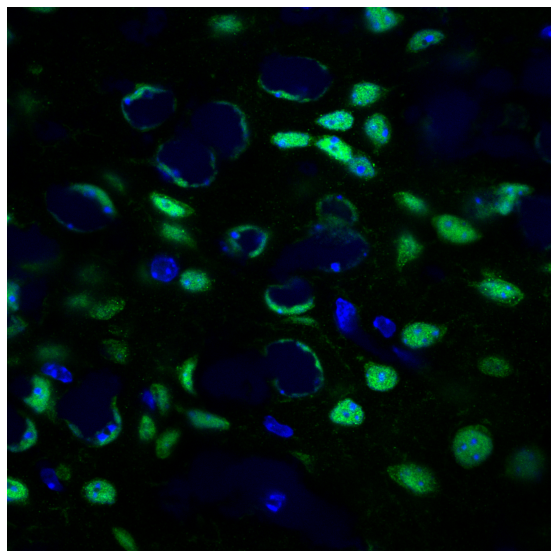

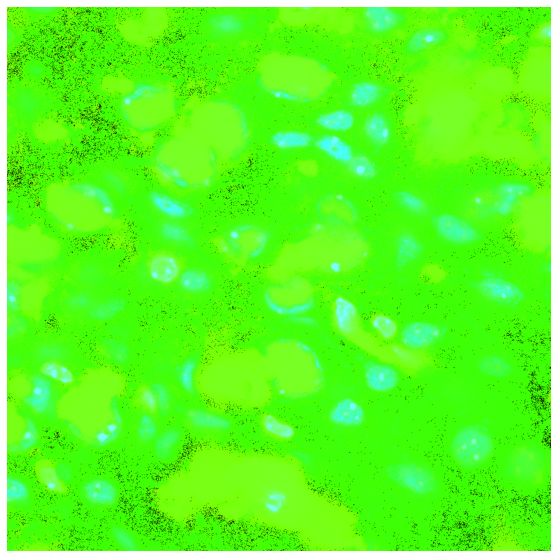

In [ ]:
#Iniciamos cargando la imagen que se usara.
img = cv2.imread('/content/63x-NeuN-Hoechst-izq-18 ZEN.tif') #Aqui la imagen se le como BGR asi que se debe pasar a RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Aqui ya se puede apreciar el tono azul que en otro caso se veria como rojo
#Aunque ese cambio es solo para imprimir la imagen, por lo que ocupamos es que este en hsv

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  #cambiamos a HSV ya que los colores se perciben mucho más brillantes y es más fácil de segmentar

#Ploteamos las dos imagenes
plt.figure(figsize=(10,10)),plt.axis('off')
plt.imshow(img)
plt.show()
plt.figure(figsize=(10,10)),plt.axis('off')
plt.imshow(hsv)
plt.show()

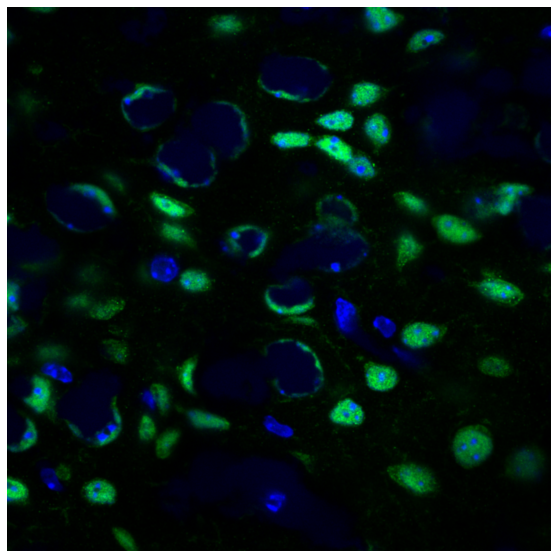

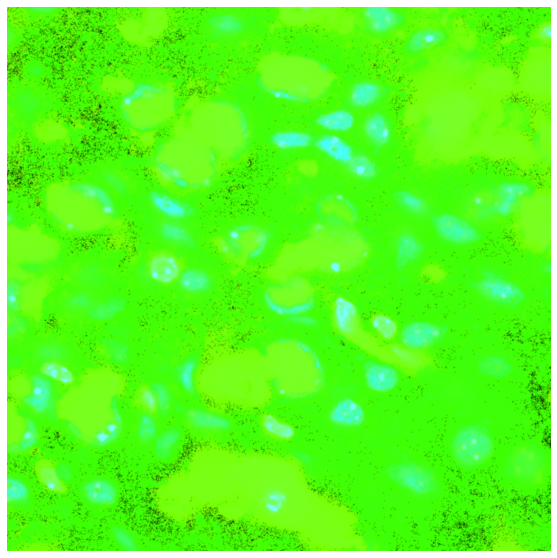

In [ ]:
#Antes de hacer cualquier segmentación aplique un suavizado guassiano que me dio muy buenos resultados
#Esto en base a la recomendación del doctor en el documento del proyecto
hsv_gauss =  cv2.GaussianBlur(hsv, (3,3), 0, borderType= cv2.BORDER_REPLICATE)
imag_gauss = cv2.GaussianBlur(img, (3,3), 0, borderType= cv2.BORDER_REPLICATE)

plt.figure(figsize=(10,10)),plt.axis('off')
plt.imshow(imag_gauss)
plt.show()
plt.figure(figsize=(10,10)),plt.axis('off')
plt.imshow(hsv_gauss)
plt.show()

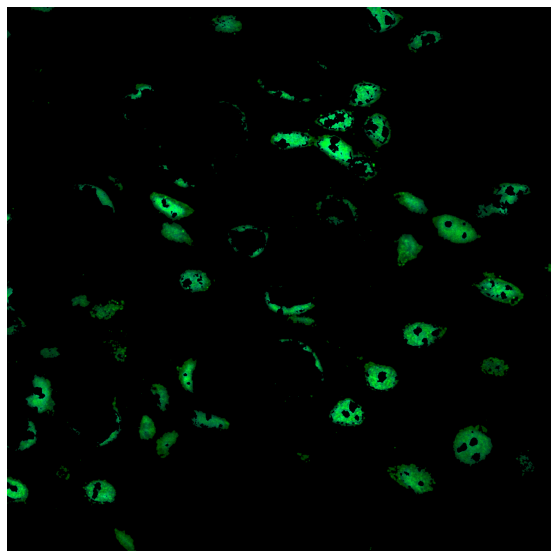

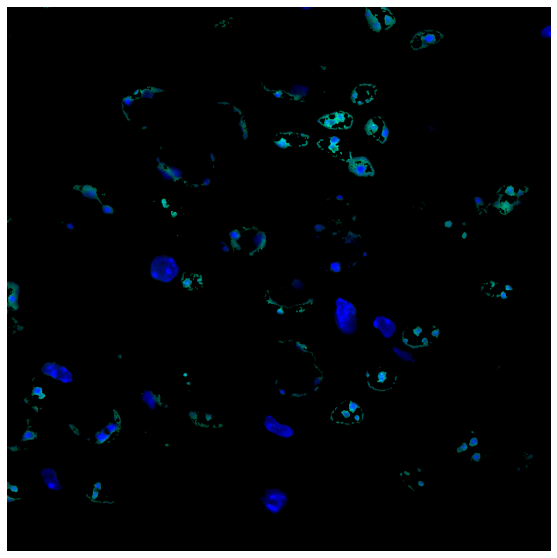

In [ ]:
#El siguiente paso es generar las máscaras para segmentar por colores cada elemento.
#lower_azul = np.array([100,100,20])
#upper_azul = np.array([125,255,255])
#Rangos del color verde en hsv
lower_verde = np.array([20,50,50])
upper_verde = np.array([80,255,255])
lower_c3 = np.array([80,50,50]) 
upper_c3 = np.array([125,255,255])

#Creamos las mascaras con estos rangos especificamente
# Umbralizar la imagen HSV para obtener solo los colores deseados
mask = cv2.inRange(hsv_gauss, lower_verde, upper_verde)
mask1 = cv2.inRange(hsv_gauss,lower_c3, upper_c3)
#mask2 = cv2.inRange(hsv_gauss, lower_azul, upper_azul)

# Se ocupa una máscara Bitwise-AND y la imagen original 
green_cell = cv2.bitwise_and(img,img, mask= mask)
c3_cell = cv2.bitwise_and(img,img,mask=mask1)
#blue_cell = cv2.bitwise_and(img,img, mask= mask2)

#Mostramos las imagenes ya segmentadas
plt.figure(figsize=(10,10)),plt.axis('off')
plt.imshow(green_cell)
plt.show()
plt.figure(figsize=(10,10)),plt.axis('off')
plt.imshow(c3_cell)
plt.show()

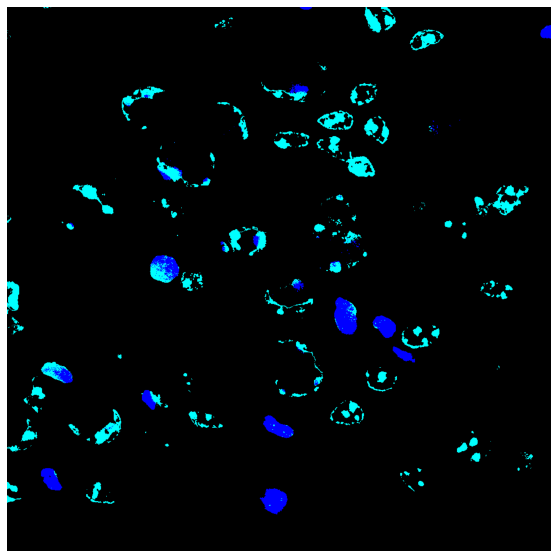

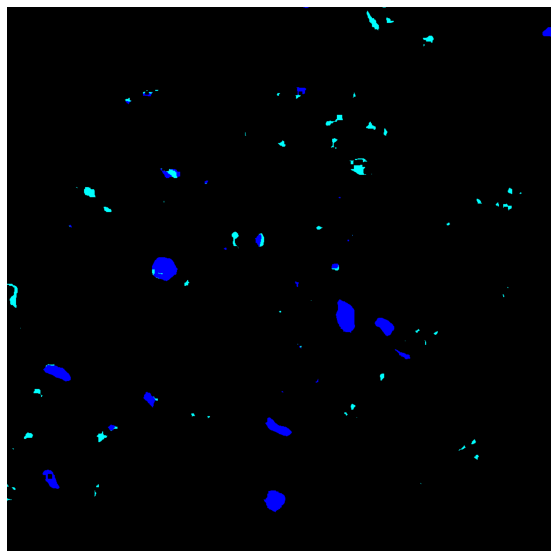

In [ ]:
c3_binary= cv2.threshold(c3_cell, 10, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY)[1]

#Ahora lo que se debe hacer para este caso es eliminar todos los elementos pequeños
#Para ello aplicamos una transformación morfologica: erosión.
c3_erode = cv2.erode(c3_binary, None, iterations=3)

plt.figure(figsize=(10,10))
plt.imshow(c3_binary, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(c3_erode, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
#Esta funcion cuenta los objetos y da parametros de ellos, como por ejemplo: areas, coordenadas, perimetro, etc. Nos enfocaremos en las dos primeras.
c3_gray = cv2.cvtColor(c3_erode, cv2.COLOR_BGR2GRAY) #debemos pasar la imagen a blanco y negro
#total_cell = numero de objetos contantos
#label = asignacion automatica de la funcion a cada objeto
#stats = area del objeto
#centroids = coordenadas del centro de cada objeto encontrado
total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(c3_gray, 8, cv2.CV_32S)

print("Total cells are:",total_cell -1) #Va en -1 porque toma como el fondo como un elemento, entonces se debe quitar.

Total cells are: 94


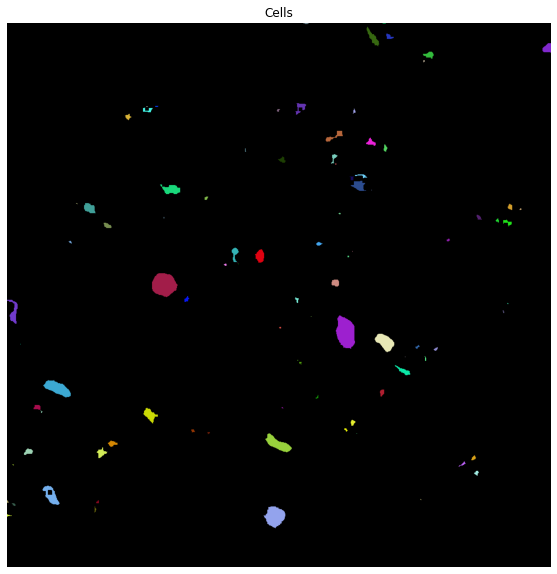

In [ ]:
#Estas lineas de codigo asigna un color randon a cada objeto detectado por su label, el fondo lo manda a 0
colors = np.random.randint(0,255,size = (total_cell,3), dtype = np.uint8)
colors[0] = [0,0,0]
colored_components = colors[label]
plt.figure(figsize=(10,10))
plt.imshow(colored_components)
plt.title("Cells"), plt.axis('off')
plt.show()

In [ ]:
#Para eliminar los objetos que no deseamos se pasa un filtro por áreas, para eliminar las más pequeñas
#Para ello primero imprimimos todas las áreas encontradas
size= stats[1:,-1]
print(np.sort(size)[::-1])

[1638 1606 1100  906  775  745  532  437  372  366  319  306  304  301
  219  213  192  187  186  184  158  154  136  133  125  102   96   93
   91   87   86   86   79   75   71   65   63   62   59   56   52   48
   47   39   38   37   32   31   29   28   28   25   23   23   22   22
   21   20   18   17   17   16   15   15   15   13   11   10   10   10
    9    9    8    8    7    7    6    6    6    4    3    3    3    3
    2    2    2    1    1    1    1    1    1    1]


In [ ]:
#Elimando los elementos de menor area
sizes = stats[1:,-1]
total_cell = total_cell-1
imag_c3 = c3_gray
for i in range(0, total_cell):
  if sizes[i] < 500: 
    imag_c3[label == i+1] =0 

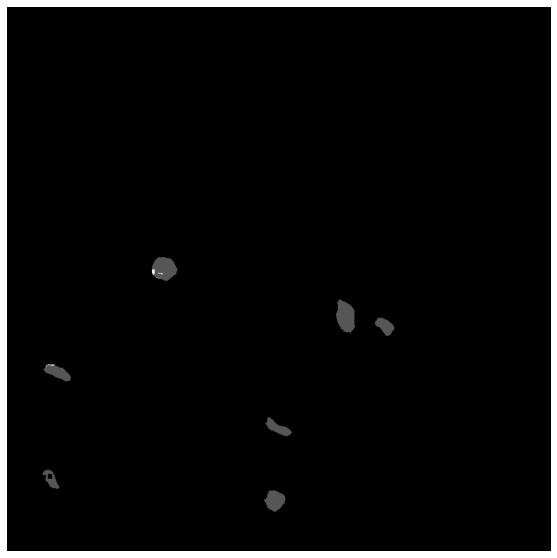

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(imag_c3, cmap='gray'), plt.axis('off')
plt.show()

In [ ]:
#Podemos volver a contar las células que se encontraron para comprobar
total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(imag_c3, 8, cv2.CV_32S)

print("Total cells are:",total_cell -1) #Va en -1 porque toma como el fondo como un elemento, entonces se debe quitar.

Total cells are: 7


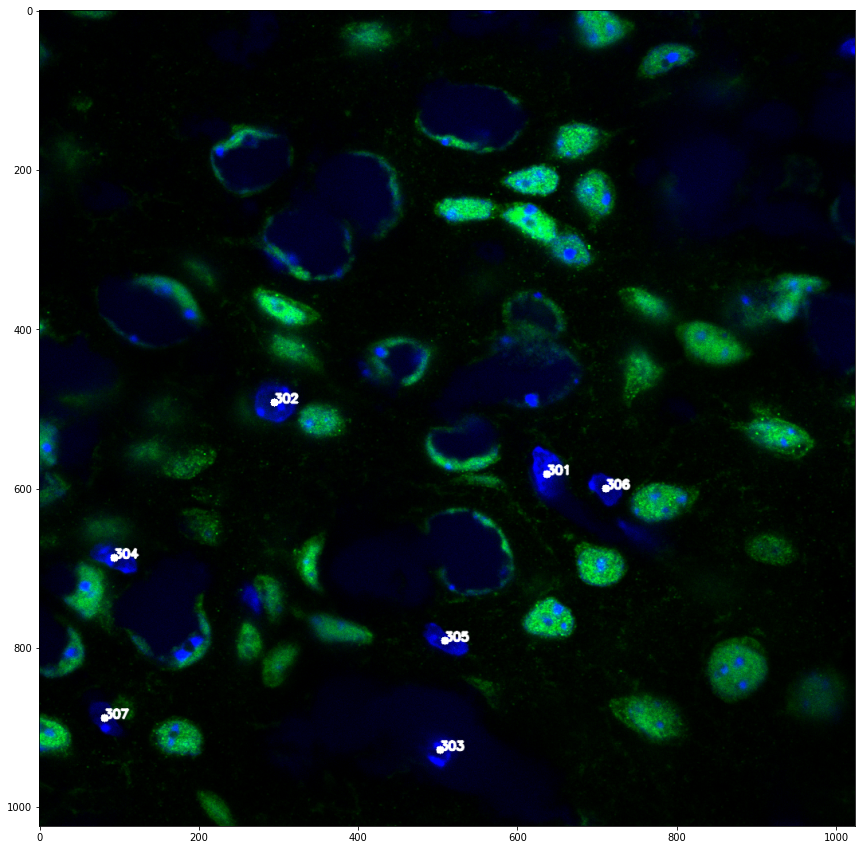

In [ ]:
#Aqui realizara un corteneo sobre cada uno de los elementos que se detectaron 
#Y los guarda al azar en sorted_contours
contours, hierarchy= cv2.findContours(imag_c3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

for (i,c) in enumerate(sorted_contours):
   M = cv2.moments(c)
 
   # Obtenemos las coordenadas en x y y del centro de cada celula
   cX = int(M["m10"] / M["m00"])
   cY = int(M["m01"] / M["m00"])
   #Agregamo una marca en el centro de cada celula encontrada
   cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
   #Enumeramos las celulas
   cv2.putText(img, text= "30"+str(i+1), org=(cX,cY),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255),
            thickness=2, lineType=cv2.LINE_AA)
   
# Mostramos la imagen original con la modificacion
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

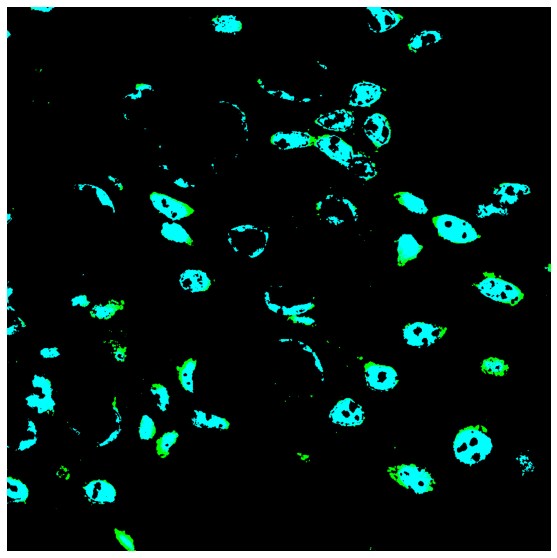

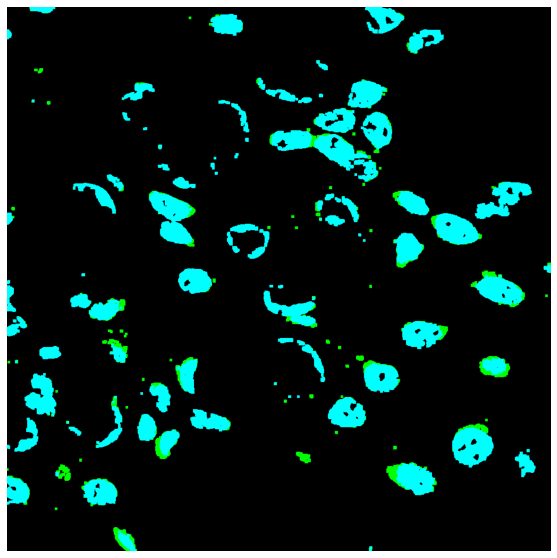

In [ ]:
#Iniciamos con las transformaciones del verde
#Como la segmentación de la máscara verde dejo muchas cosas incompletas empece con una dilatación para intentar rellenar espacios faltantes
green_binary= cv2.threshold(green_cell, 10, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY)[1]
green_dilate = cv2.dilate(green_binary, None, iterations=2)

plt.figure(figsize=(10,10))
plt.imshow(green_binary, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(green_dilate, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
green_gray = cv2.cvtColor(green_dilate, cv2.COLOR_BGR2GRAY)

#Imprimimos el total de celulas
total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(green_gray, 8, cv2.CV_32S)

print("Total cells are:",total_cell -1)


Total cells are: 135


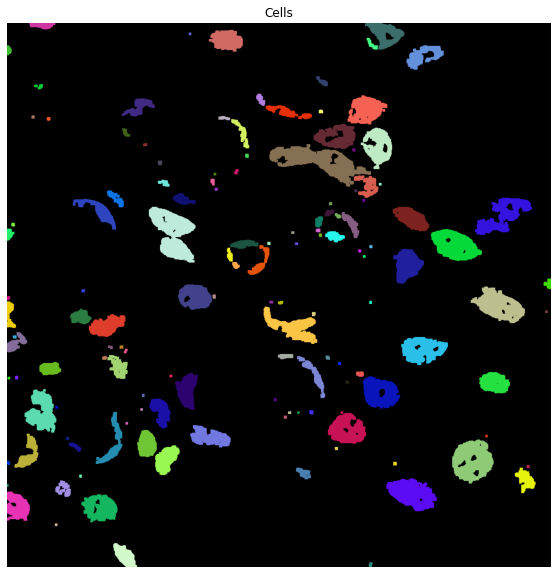

In [ ]:
#Mostramos cada célula con colores random
colors = np.random.randint(0,255,size = (total_cell,3), dtype = np.uint8)
colors[0] = [0,0,0]
colored_components = colors[label]
plt.figure(figsize=(10,10))
plt.imshow(colored_components)
plt.title("Cells"), plt.axis('off')
plt.show()

In [ ]:
#Imprimos las áreas
size= stats[1:,-1]
print(np.sort(size)[::-1])

[5997 5030 4500 3898 3836 3778 3495 3144 3054 3016 2931 2888 2719 2646
 2571 2435 2394 2296 1996 1982 1979 1919 1914 1901 1785 1778 1677 1675
 1459 1426 1392 1390 1255 1210 1070 1066 1010  987  974  959  811  808
  743  708  690  621  608  573  565  508  505  484  438  390  255  246
  237  220  211  211  209  207  193  188  175  145  135  133  133  132
  111   89   86   65   63   60   60   59   58   58   57   53   53   53
   52   47   47   47   46   46   44   44   43   42   41   41   41   40
   40   36   36   36   36   36   36   35   35   35   35   35   35   35
   34   30   30   30   30   30   30   30   25   25   25   25   25   25
   25   25   25   25   25   25   25   25   15]


In [ ]:
#Elimando los elementos de menor area
sizes = stats[1:,-1]
total_cell = total_cell-1
imag_green = green_gray
for i in range(0, total_cell):
  if sizes[i] < 140:
    imag_green[label == i+1] =0 

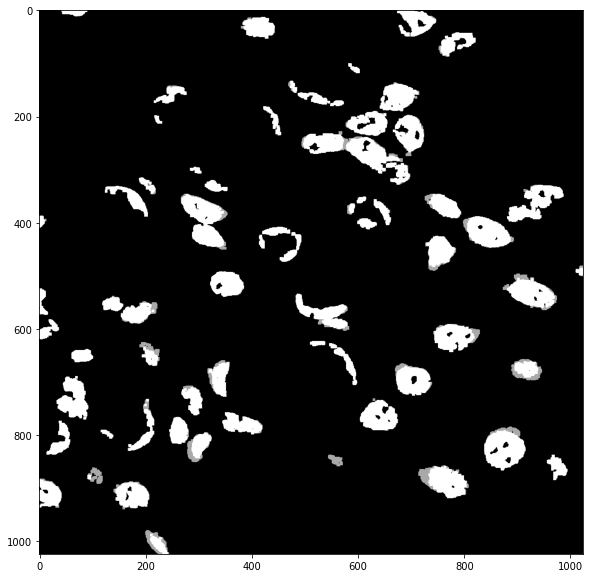

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(imag_green, cmap='gray')
plt.show()

imag_c1= imag_green.copy() #Copia para la clase 1
imag_c2 = imag_green.copy() #Copia para la clase 2

In [ ]:
#Ahora iniciamos con la clase 1
#Primero conte cuantas celulas en general tengo 
total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(imag_c1, 8, cv2.CV_32S)

print("Total cells are:",total_cell -1)

Total cells are: 66


In [ ]:
size= stats[1:,-1]
print(np.sort(size)[::-1])

[5997 5030 4500 3898 3836 3778 3495 3144 3054 3016 2931 2888 2719 2646
 2571 2435 2394 2296 1996 1982 1979 1919 1914 1901 1785 1778 1677 1675
 1459 1426 1392 1390 1255 1210 1070 1066 1010  987  974  959  811  808
  743  708  690  621  608  573  565  508  505  484  438  390  255  246
  237  220  211  211  209  207  193  188  175  145]


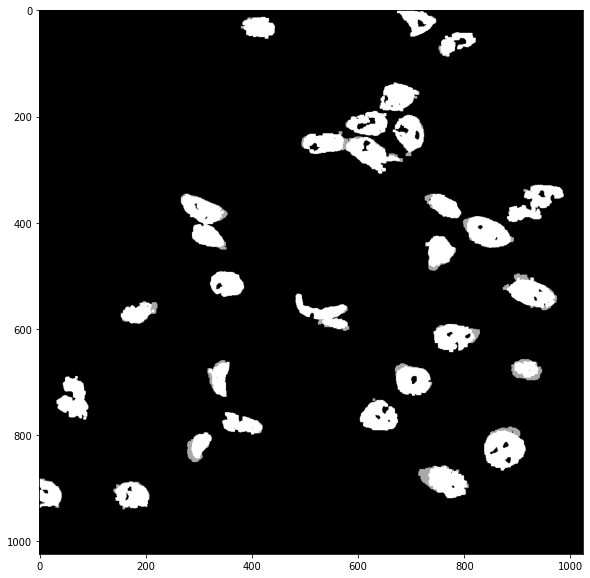

In [ ]:
#Elimando los elementos de menor area
sizes = stats[1:,-1]
total_cell = total_cell-1
imag_c1 = imag_c1
for i in range(0, total_cell):
  if sizes[i] < 1600:
    imag_c1[label == i+1] =0 

plt.figure(figsize=(10,10))
plt.imshow(imag_c1, cmap='gray')
plt.show()

In [ ]:
total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(imag_c1, 8, cv2.CV_32S)

print("Total cells are:",total_cell -1)

Total cells are: 28


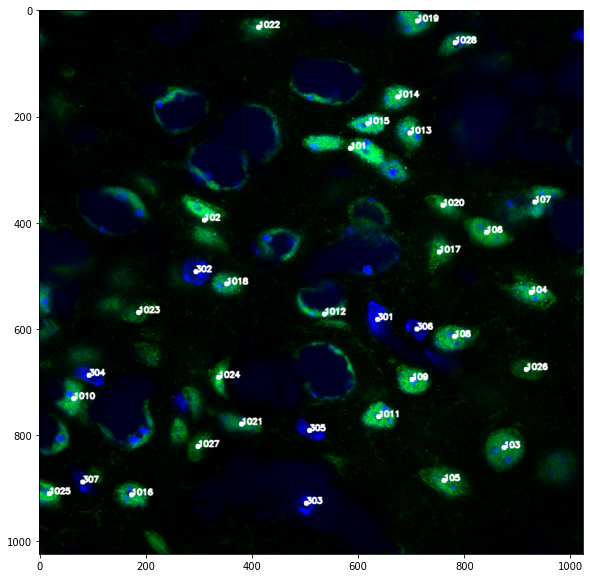

In [ ]:
#Marcamos las celulas encontradas para la clase 1
contours, hierarchy= cv2.findContours(imag_c1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

for (i,c) in enumerate(sorted_contours):
    M= cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
    cv2.putText(img, text= "10"+str(i+1), org=(cX,cY),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255),
            thickness=2, lineType=cv2.LINE_AA)

    
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

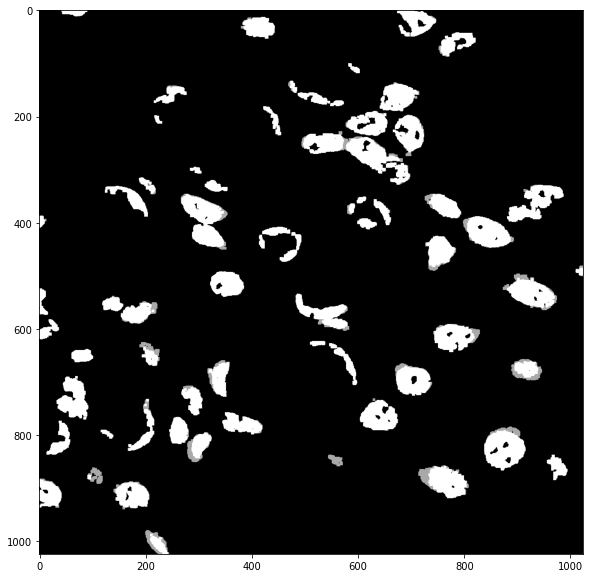

In [ ]:
#Por ultimo obtenemos la clase 2
plt.figure(figsize=(10,10))
plt.imshow(imag_c2, cmap='gray')
plt.show()

In [ ]:
total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(imag_c2, 8, cv2.CV_32S)

print("Total cells are:",total_cell -1)

size= stats[1:,-1]
print(np.sort(size)[::-1])

Total cells are: 66
[5997 5030 4500 3898 3836 3778 3495 3144 3054 3016 2931 2888 2719 2646
 2571 2435 2394 2296 1996 1982 1979 1919 1914 1901 1785 1778 1677 1675
 1459 1426 1392 1390 1255 1210 1070 1066 1010  987  974  959  811  808
  743  708  690  621  608  573  565  508  505  484  438  390  255  246
  237  220  211  211  209  207  193  188  175  145]


Total cells are: 15
[484 438 390 255 246 237 220 211 211 209 207 193 188 175 145]


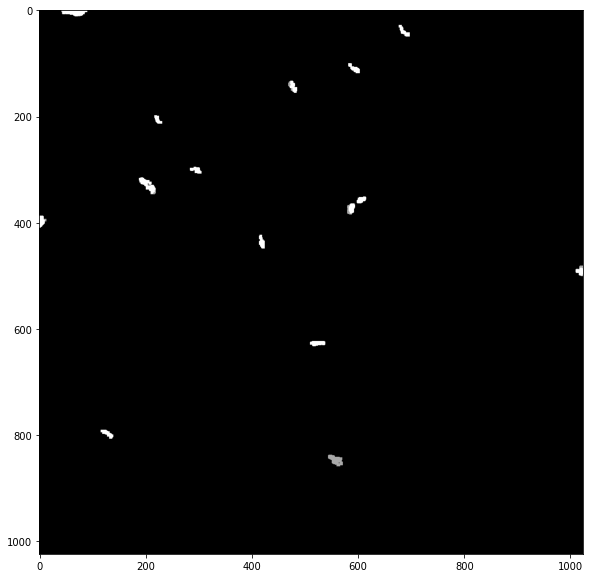

In [ ]:
#Elimando los elementos que no sean de la clase 2
sizes = stats[1:,-1]
total_cell = total_cell-1
imag_c2_1 = imag_c2
for i in range(0, total_cell):
  #Esto es para eliminar las celulas arriba de ese rango
  #Como las de la clase 1
  if sizes[i] > 500:
    imag_c2_1[label == i+1] =0
for i in range(0, total_cell):
  #Esto es para eliminar las celulas debajo del rango
  #Como son segmentos inservibles
  if sizes[i] < 60:
    imag_c2_1[label == i+1] =0

total_cell, label, stats, centroids =cv2.connectedComponentsWithStats(imag_c2_1, 8, cv2.CV_32S)
print("Total cells are:",total_cell -1)
size= stats[1:,-1]
print(np.sort(size)[::-1])

plt.figure(figsize=(10,10))
plt.imshow(imag_c2_1, cmap='gray')
plt.show()

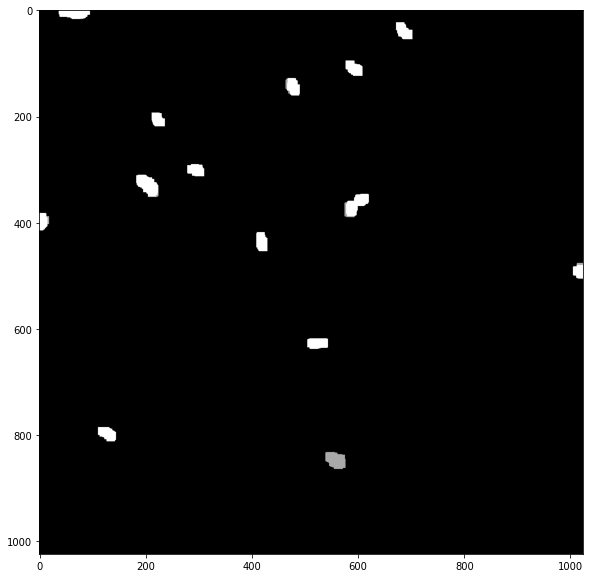

In [ ]:
imag_c2_2 = cv2.dilate(imag_c2_1, None, iterations=5)

plt.figure(figsize=(10,10))
plt.imshow(imag_c2_2, cmap='gray')
plt.show()

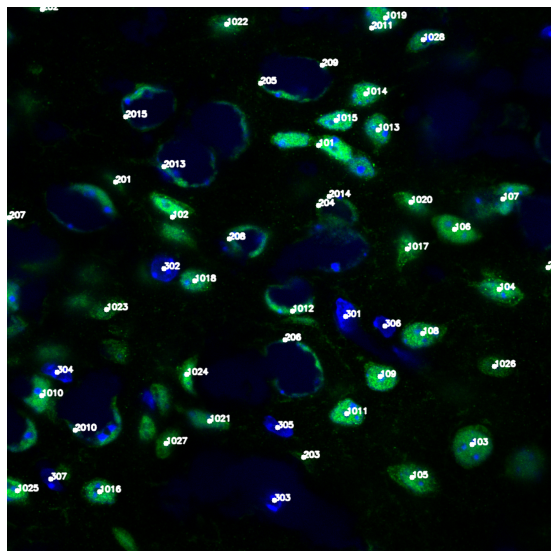

In [ ]:
#Marcamos las celulas encontradas para la clase 1
contours, hierarchy= cv2.findContours(imag_c2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)

for (i,c) in enumerate(sorted_contours):
    M= cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
    cv2.putText(img, text= "20"+str(i+1), org=(cX,cY),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255),
            thickness=2, lineType=cv2.LINE_AA)

    
plt.figure(figsize=(10,10))
plt.imshow(img), plt.axis('off')
plt.show()